In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [2]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, GlobalAveragePooling1D, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

2023-12-20 12:56:52.243339: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 12:56:52.270710: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 12:56:52.372211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 12:56:52.372254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 12:56:52.386945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
df = joblib.load('./data/word2vec_15_100.pkl')

In [4]:
X1 = np.array(df['question1'])
X2 = np.array(df['question2'])
y = np.array(df['is_duplicate'])

In [5]:
del df

In [6]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

In [7]:
def data_generator(X1, X2, y, batch_size, epochs):
    num_samples = X1.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))

    for epoch in range(epochs):
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
    
            batch_indices = np.arange(start_idx, end_idx)
            
            X1_batch = np.array(X1[batch_indices].tolist())
            X2_batch = np.array(X2[batch_indices].tolist())

            y_batch = np.array(y[batch_indices].tolist())
            
            yield [X1_batch, X2_batch], y_batch

In [8]:
input_shape = (15, 100)

input_1 = Input(shape=input_shape, name='input1')
input_2 = Input(shape=input_shape, name='input2')

branch_1 = Dense(128, activation='relu')(input_1)
branch_1 = BatchNormalization()(branch_1)
branch_1 = Dropout(0.5)(branch_1)
branch_1 = Dense(64, activation='relu')(branch_1)
branch_1 = BatchNormalization()(branch_1)
branch_1 = Dropout(0.5)(branch_1)
branch_1 = Dense(32, activation='relu')(branch_1)

branch_2 = Dense(128, activation='relu')(input_2)
branch_2 = BatchNormalization()(branch_2)
branch_2 = Dropout(0.5)(branch_2)
branch_2 = Dense(64, activation='relu')(branch_2)
branch_2 = BatchNormalization()(branch_2)
branch_2 = Dropout(0.5)(branch_2)
branch_2 = Dense(32, activation='relu')(branch_2)

pooled_1 = GlobalAveragePooling1D()(branch_1)
pooled_2 = GlobalAveragePooling1D()(branch_2)

merged = Concatenate()([pooled_1, pooled_2])

merged = Dense(64, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.5)(merged)
merged = Dense(64, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.5)(merged)
merged = Dense(64, activation='relu')(merged)

output = Dense(1, activation='sigmoid', name='output')(merged)

model = Model(inputs=[input_1, input_2], outputs=output)

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 15, 100)]            0         []                            
                                                                                                  
 input2 (InputLayer)         [(None, 15, 100)]            0         []                            
                                                                                                  
 dense (Dense)               (None, 15, 128)              12928     ['input1[0][0]']              
                                                                                                  
 dense_3 (Dense)             (None, 15, 128)              12928     ['input2[0][0]']              
                                                                                              

In [11]:
batch_size = 100
epochs = 20

train_generator = data_generator(X1_train, X2_train, y_train, batch_size, epochs)
validation_generator = data_generator(X1_test, X2_test, y_test, batch_size, epochs)

steps_per_epoch = int(np.ceil(X1_train.shape[0] / batch_size))
validation_steps = int(np.ceil(X1_test.shape[0] / batch_size))

In [12]:
history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, verbose=1)

Epoch 1/20
3235/3235 [==============================] - 65s 19ms/step - loss: 0.6027 - accuracy: 0.6769 - val_loss: 0.5618 - val_accuracy: 0.7132
Epoch 2/20
3235/3235 [==============================] - 62s 19ms/step - loss: 0.5663 - accuracy: 0.7081 - val_loss: 0.5459 - val_accuracy: 0.7235
Epoch 3/20
3235/3235 [==============================] - 61s 19ms/step - loss: 0.5573 - accuracy: 0.7148 - val_loss: 0.5389 - val_accuracy: 0.7287
Epoch 4/20
3235/3235 [==============================] - 59s 18ms/step - loss: 0.5514 - accuracy: 0.7179 - val_loss: 0.5349 - val_accuracy: 0.7328
Epoch 5/20
3235/3235 [==============================] - 62s 19ms/step - loss: 0.5470 - accuracy: 0.7215 - val_loss: 0.5364 - val_accuracy: 0.7333
Epoch 6/20
3235/3235 [==============================] - 60s 18ms/step - loss: 0.5445 - accuracy: 0.7233 - val_loss: 0.5332 - val_accuracy: 0.7358
Epoch 7/20
3235/3235 [==============================] - 61s 19ms/step - loss: 0.5419 - accuracy: 0.7251 - val_loss: 0.5318 -

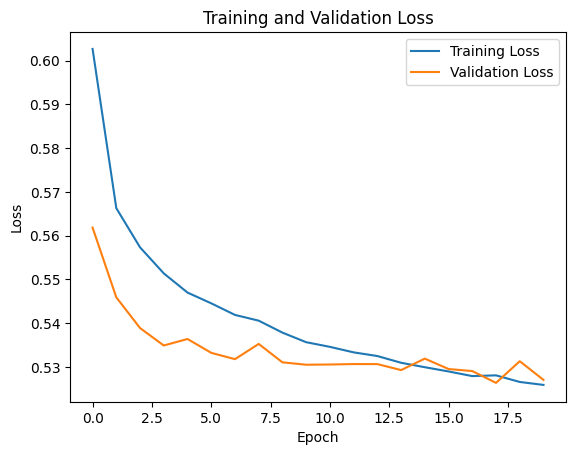

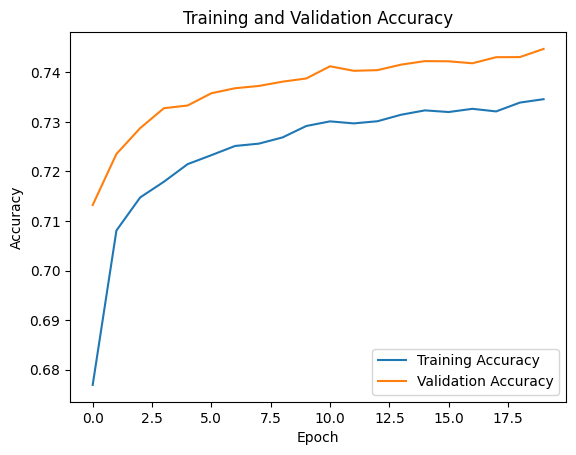

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

809/809 [==============================] - 8s 9ms/step
Accuracy: 0.7448242598135002
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81     50803
           1       0.69      0.56      0.62     30055

    accuracy                           0.74     80858
   macro avg       0.73      0.71      0.71     80858
weighted avg       0.74      0.74      0.74     80858



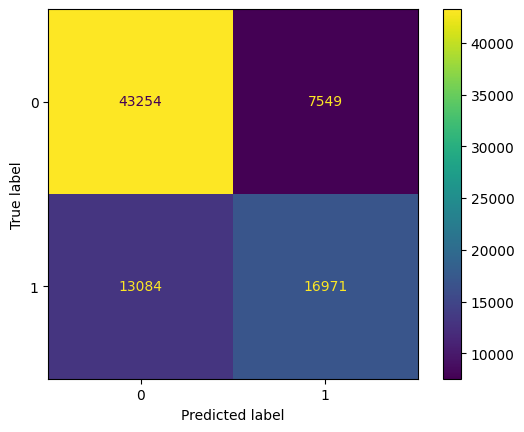

In [14]:
validation_generator = data_generator(X1_test, X2_test, y_test, batch_size, epochs)
y_pred_prob = model.predict(validation_generator, steps=validation_steps)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()